Number of unique categories: 24
Number of unique web services: 141
Number of unique links: 2344392


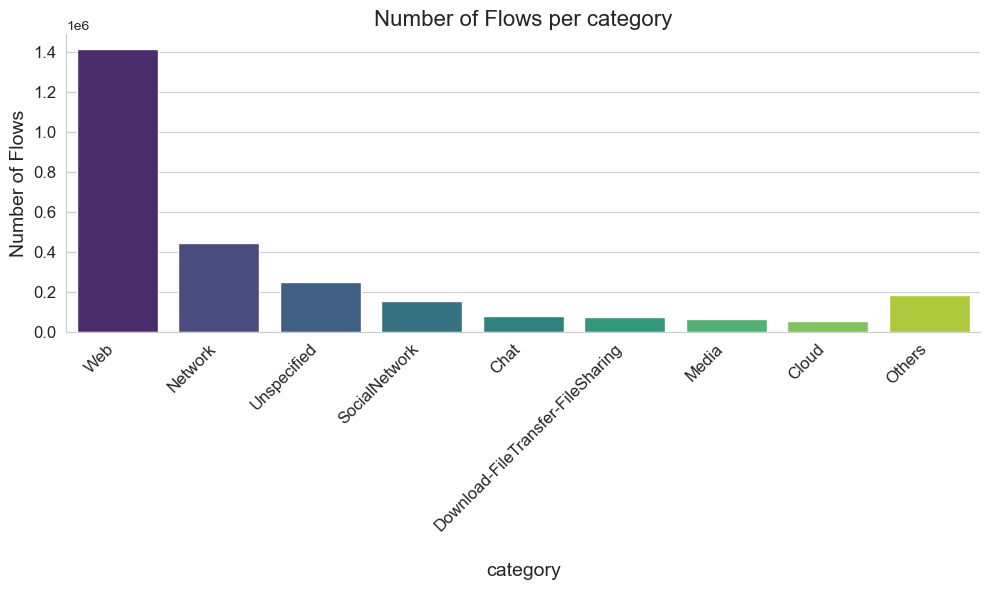

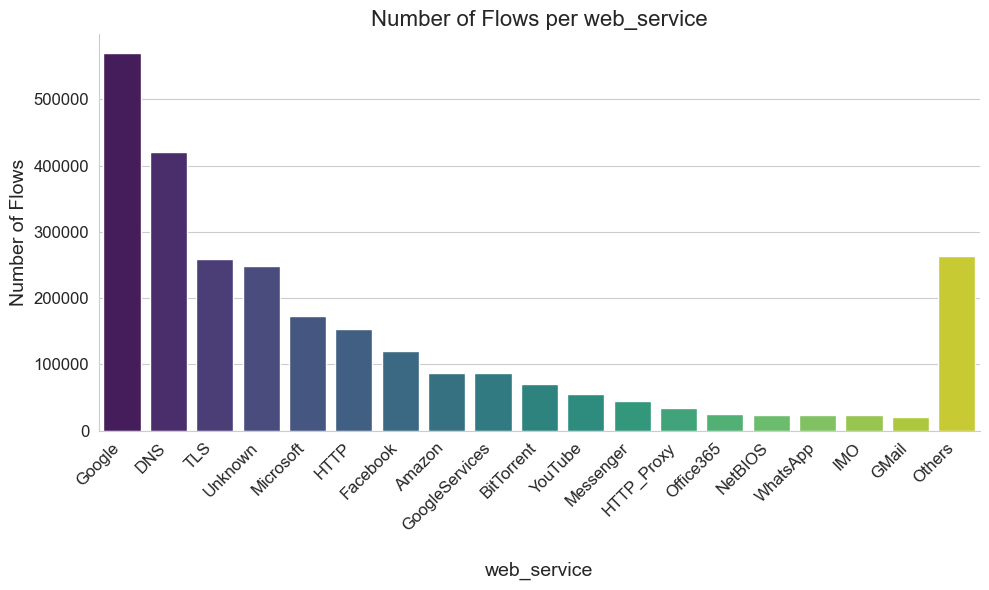

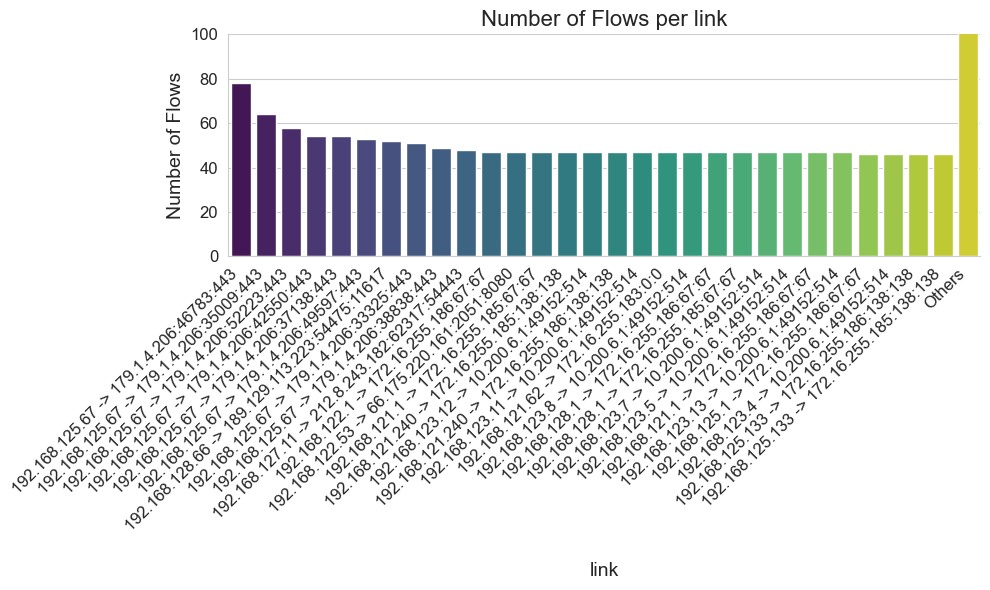

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "../../web_service_dataset.csv"
df = pd.read_csv(file_path)

# 1.1
unique_categories = df['category'].nunique()
unique_web_services = df['web_service'].nunique()

df['link'] = df['src_ip'] + ' -> ' + df['dst_ip']  + ':' + df['src_port'].astype(str) + ':' + df['dst_port'].astype(str)
unique_links = df['link'].nunique()

print(f"Number of unique categories: {unique_categories}")
print(f"Number of unique web services: {unique_web_services}")
print(f"Number of unique links: {unique_links}")

df_categories = ['category', 'web_service', 'link']
threshold = [50000, 20000, 45]

# For each of the three entities, draw a bar plot indicating the number of flows belong to a class
# for a certain entity. If there are some targets (e.g., a certain web service) that have
# too few samples, group them as “others”

for index, elem in enumerate(df_categories):
    flow_by_elem = df.groupby(elem)[df_categories[index]]
    flow_count = flow_by_elem.count()
    flow_by_count = flow_count.sort_values(ascending=False)
    count_other = flow_by_count[flow_by_count.values < threshold[index]].sum()
    other_row = pd.Series(count_other, index=['Others'])
    flow_by_count = flow_by_count[flow_by_count > threshold[index]]
    flow_by_count = pd.concat([flow_by_count, other_row])
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=flow_by_count.index, y=flow_by_count.values, hue=flow_by_count.index, palette='viridis', legend=False)
    plt.title(f'Number of Flows per {elem}', fontsize=16)
    plt.xlabel(f'{elem}', fontsize=14, labelpad=20)
    plt.ylabel("Number of Flows", fontsize=14)
    if elem == 'link':
        plt.ylim(0, 100)  # Set y-axis limit for 'link'
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [309]:
# 1.2
from sklearn.preprocessing import LabelEncoder

# How many unique protocols are there in the dataset?
unique_proto = df['proto'].unique()
    
print(f"Number of unique proto: {len(unique_proto)}")

# Convert such a categorical feature into a numerical one through one-hot encoding.
one_hot_proto = pd.get_dummies(df['proto'], prefix='proto')

# Convert string labels (category and web service) into numerical classes.

label_encoder_category = LabelEncoder()
label_encoder_service = LabelEncoder()
category_numerical_class = label_encoder_category.fit_transform(df['category'])
web_service_numerical_class = label_encoder_service.fit_transform(df['web_service'])

print(category_numerical_class)
print(web_service_numerical_class)

Number of unique proto: 3
[11 11 11 ... 18 23 23]
[17 17 17 ... 64 31 31]


In [275]:
# 1.3

# Do you find features that only have a constant value?

numeric_df = df.select_dtypes(include=['number']) 
constant_features = [col for col in numeric_df if numeric_df[col].var() == 0]

print(f"Constant features: {constant_features}")

if len(constant_features) > 0:
    df = df.drop(columns=constant_features)
    
# Do you find features that have low variance? If yes, do you think whether we should remove them or not?

column_variances = numeric_df.var()
print("Variance of numeric features:")
print(column_variances)

mean_variance = column_variances.mean()
print("Mean variance of numeric features:")
print(mean_variance)

low_variance_features = [col for col in numeric_df if numeric_df[col].var() < 0.000001 * mean_variance]
high_variance_features = [col for col in numeric_df if numeric_df[col].var() >= 0.000001 * mean_variance]

num_of_low_variance = len(low_variance_features)

num_of_high_variance = len(high_variance_features)

print(f"Low variance features: {num_of_low_variance}")

print(f"High variance features: {num_of_high_variance}")


Constant features: []
Variance of numeric features:
src_port             1.736385e+08
dst_port             8.476540e+07
pktTotalCount        1.447550e+07
octetTotalCount      2.975252e+13
min_ps               3.628413e+03
max_ps               8.639145e+06
avg_ps               1.167117e+05
std_dev_ps           2.869658e+05
flowStart            2.594312e+12
flowEnd              2.594311e+12
flowDuration         3.318399e+04
min_piat             1.078482e+03
max_piat             7.579242e+03
avg_piat             1.507452e+03
std_dev_piat         7.698087e+02
f_pktTotalCount      3.845291e+06
f_octetTotalCount    8.488694e+12
f_min_ps             4.604686e+03
f_max_ps             5.784223e+05
f_avg_ps             4.105634e+04
f_std_dev_ps         4.774176e+04
f_flowStart          2.594312e+12
f_flowEnd            6.004296e+23
f_flowDuration       3.220899e+04
f_min_piat           2.318764e+03
f_max_piat           7.283191e+03
f_avg_piat           2.686449e+03
f_std_dev_piat       5.957556e

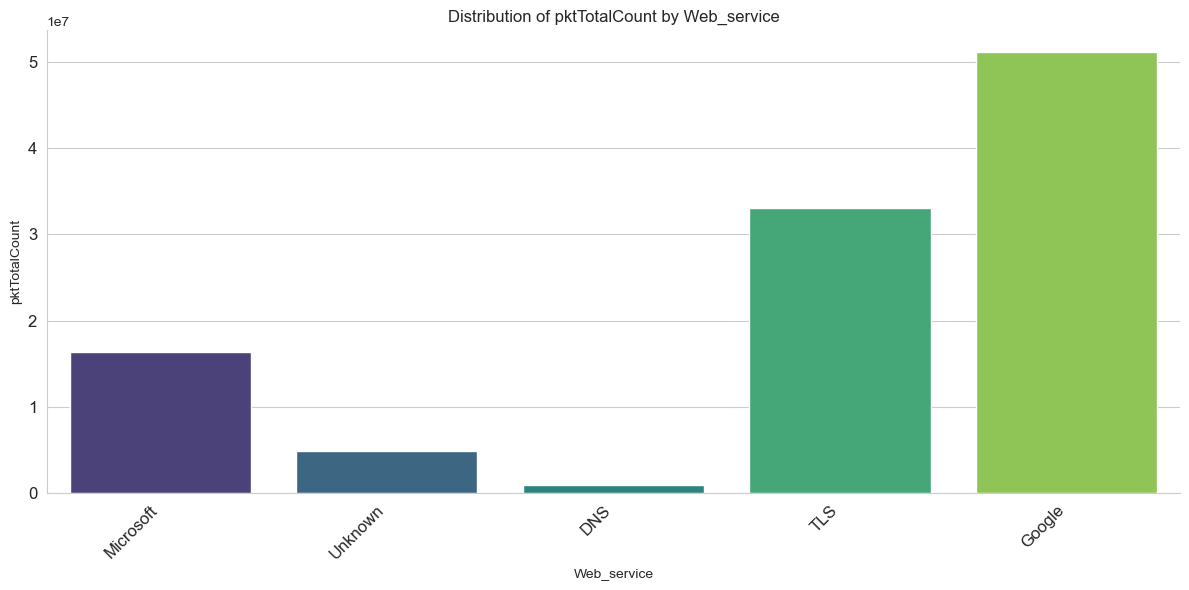

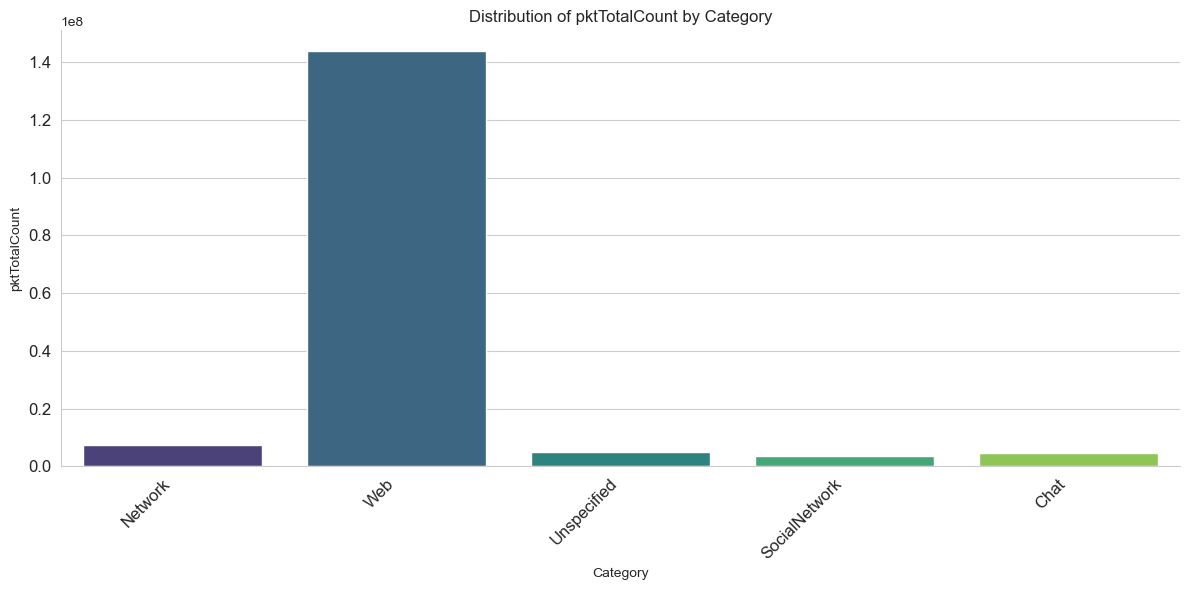

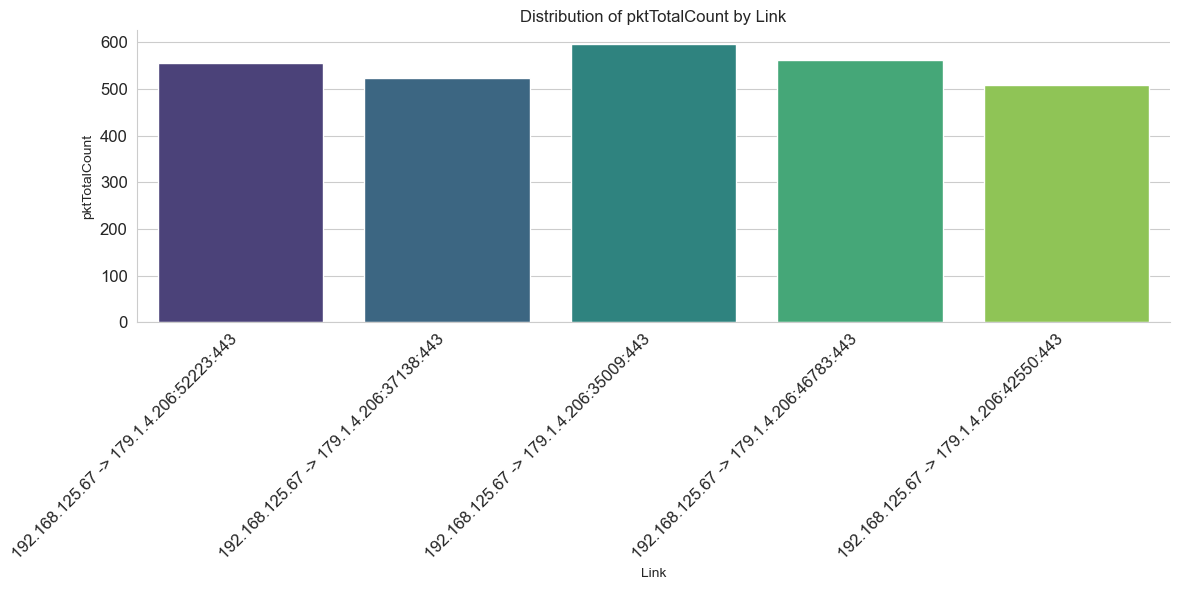

In [277]:
# 1.4

# Step 1: Check the frequency of 'web_service' and 'category' values
service_counts = df['web_service'].value_counts()
category_counts = df['category'].value_counts()
link_counts = df['link'].value_counts()

# Select the top 5 services and categories with sufficient samples
top_services = service_counts.head(5).index
top_categories = category_counts.head(5).index
top_links = link_counts.head(5).index

# Step 2: Choose a feature for visualization (e.g., 'pktTotalCount')
feature = 'pktTotalCount'

data_dict = {
    'web_service': (df[df['web_service'].isin(top_services)], 'web_service'),
    'category': (df[df['category'].isin(top_categories)], 'category'),
    'link': (df[df['link'].isin(top_links)], 'link')
}

for key, (data, x_label) in data_dict.items():
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data,
        x=x_label,
        y=feature,
        hue=x_label,  # Assign the x variable to hue
        palette='viridis',
        estimator=sum,  # Aggregate values for each category
        errorbar=None,  # Disable confidence intervals
        dodge=False  # Prevent bars from being split
    )
    plt.title(f"Distribution of {feature} by {x_label.capitalize()}")
    plt.xlabel(x_label.capitalize())
    plt.ylabel(feature)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    plt.show()


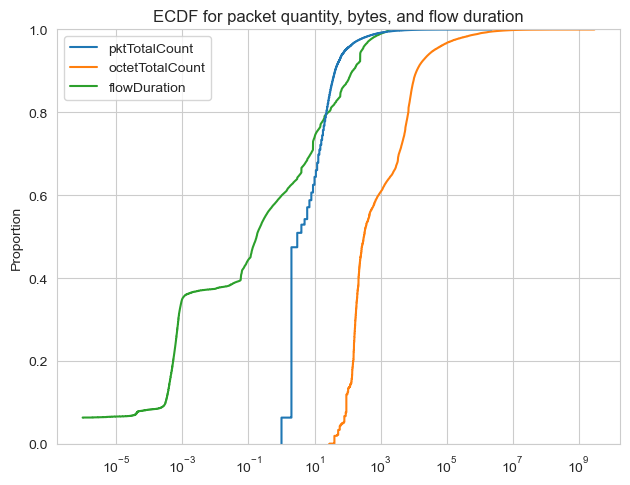

In [308]:
# 1.5

# Perform 3 ECDF plots for packet quantity, bytes, and flow duration for entire, forward, and backward traffic

sns.ecdfplot(data=df[['pktTotalCount', 'octetTotalCount', 'flowDuration']], log_scale=True)
plt.tight_layout()
plt.title('ECDF for packet quantity, bytes, and flow duration')
plt.show()

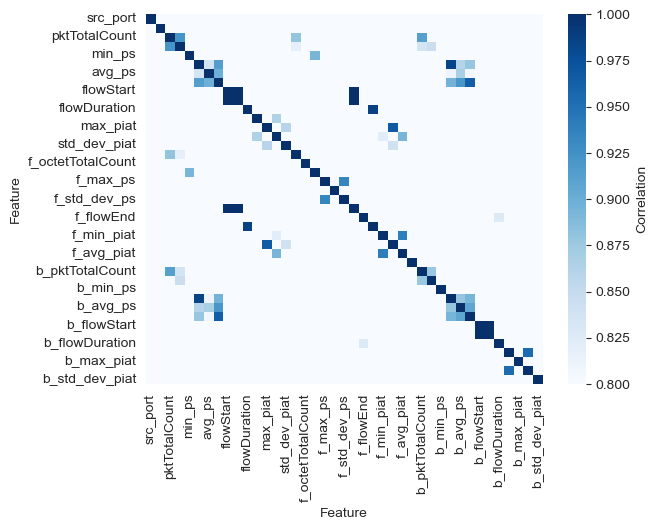

21 features are removed


In [297]:
# 1.6
correlation_matrix = numeric_df.corr().abs()
plt.figure()
sns.heatmap(correlation_matrix, cmap='Blues', vmin=0.8, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.show()

c = correlation_matrix[correlation_matrix>0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

to_be_deleted = []
candidates = list(so["level_0"])

subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])): 
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the index of columns that you need to remove from both training and test sets
print(len(to_be_deleted), 'features are removed')